# Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

# For Text Preprocessing
import re

# For Splitting the data
from sklearn.model_selection import train_test_split

# For Feature Scaling
from sklearn.preprocessing import RobustScaler

# For Imputing missing values
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

# For loading sklearn transformers & models
import joblib
import pickle 

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Interpretability
import lime.lime_tabular

pd.set_option('display.max_columns', None)

# Define classes & functions

## Cleaning Price

In [2]:
def filter_price(df):
    dropped_data = df[(df.price < 1000) | (df.price > 70000)].index
    df.drop(dropped_data, axis = 0, inplace = True)
    
    print('"Price" filtered\n')
    return df

## Cleaning odometer

In [3]:
def filter_odometer(df):
    dropped_data = df[df.odometer >= 1000000].index
    df.drop(dropped_data, axis = 0, inplace = True)
    
    print('"Odometer" filtered\n')
    return df

## Encode categorical features

In [4]:
def encode_cylinders(df):
    df['cylinders'] = [float(d) for d in df.cylinders.str.extract(r'(\d+)')[0]]
    
    print('"Cylinders" encoded\n')
    return df

In [5]:
def encode_condition(df):
    condition_dict = {'salvage':0,
                     'fair':1,
                     'good':2,
                     'excellent':3,
                     'like new':4,
                     'new':5}

    df['condition'].replace(condition_dict, inplace = True)
    
    print('"Condition" encoded\n')
    return df

In [6]:
def encode_fuel(df):
    fuel_dict = {'gas':1,
                'other':0,
                'diesel':0,
                'hybrid':0,
                'electric':0}

    df['fuel'].replace(fuel_dict, inplace = True)
    df.rename(columns = {'fuel':'fuel_gas'}, inplace = True)
    
    print('"Fuel" encoded\n')
    return df

In [7]:
def encode_title_status(df):
    title_status_dict = {'clean':1,
                'rebuilt':1,
                'salvage':0,
                'lien':0,
                'missing':0,
                'parts only':0}

    df['title_status'].replace(title_status_dict, inplace = True)
    df.rename(columns = {'title_status':'title_status_ok'}, inplace = True)
    
    print('"Title status" encoded\n')
    return df

In [8]:
def encode_transmission(df):
    transmission_dict = {'automatic':1,
                        'other':0,
                        'manual':0}
    
    df['transmission'].replace(transmission_dict, inplace = True)
    df.rename(columns = {'transmission':'transmission_automatic'}, inplace = True)
    
    print('"Transmission" encoded\n')
    return df

In [9]:
def encode_type(df):
    top_4_type = df.type.value_counts()[:4].index
    
    df.type = ['other' if car_type not in top_4_type else car_type for car_type in df.type] 
    
    print('"Type" encoded\n')
    return df

In [10]:
def encode_paint_color(df):
    d = {'silver':'grey'}
    df.paint_color.replace(d, inplace = True)
    
    top_4_colors = ['white', 'grey', 'black', 'blue']
    
    df.paint_color = ['other' if color not in top_4_colors else color for color in df.paint_color]
    
    print('"Paint_color" encoded\n')
    return df

## Feature Engineering with External/Scraped Data

In [11]:
def states_to_regions(df, states_data):
    states_data['State Code'] = [code.lower() for code in states_data['State Code']]
    
    region_values = states_data['Region'].values
    state_code = states_data['State Code']

    d_regions = dict(zip(state_code, region_values))
    
    df.state.replace(d_regions, inplace = True)
    df.rename(columns = {'state':'regions_usa'}, inplace = True)
    
    print('"States" data encoded into Regions\n')
    return df

In [12]:
def manufacturers_origin(df, manufacturers_data):
    # Change some compounds name on dataset
    d_mod = {}
    for brand in set(df.manufacturer):
        if type(brand) == str:
            if ('-' in brand) and (brand != 'mercedes-benz'):
                d_mod[brand] = re.sub('-',' ',brand)
    
    df.manufacturer.replace(d_mod, inplace = True)
    
    # Create dictionary "manufacturer - continent"
    dict_cars_origin = {}

    for brand in set(df.manufacturer):
        if len(manufacturers_data[manufacturers_data.isin([f'{brand}'])].stack()) > 0:
            dict_cars_origin[f'{brand}'] = manufacturers_data[manufacturers_data.isin([f'{brand}'])].stack().index[0][1]
    
    # Adding missing brands
    dict_cars_origin['saturn'] = 'north america '
    dict_cars_origin['rover'] = 'europe '
    dict_cars_origin['pontiac'] = 'north america '
    dict_cars_origin['mercury'] = 'north america '
    dict_cars_origin['harley davidson'] = 'north america '
    
    # Replacing manufacturers
    df.manufacturer = df.manufacturer.replace(dict_cars_origin)
    
    print('"Manufacturer" data regrouped by manufacturer origin (continent)\n')
    return df

## Defining functions to apply fit/transform methods from sklearn

In [13]:
def apply_imputer(df):
    # Filter rows with too many missing values
    rows_to_drop = df[test_set.isnull().sum(axis = 1) > 4].index
    
    df.drop(rows_to_drop, axis = 0, inplace = True)
    
    df.reset_index(inplace = True, drop = True)
    
    # One-Hot encode categorical features
    df = pd.get_dummies(df)
    dummies_to_drop = ['manufacturer_europe ', 'drive_4wd', 'type_other', 'paint_color_other', 'regions_usa_Northeast']
    
    df.drop(dummies_to_drop, axis = 1, inplace = True)
        
        
    # Apply imputer
    imp = joblib.load('iterative_imputer.joblib')
    df_imp = imp.transform(df)
    
    
    df = pd.DataFrame(df_imp, columns = df.columns)
    
    print('Missing data handled with Iterative Imputer')
    return df

In [14]:
def apply_robust_feature_scaling(df):
    X_test, y_test = df.iloc[:, 1:].values, df.iloc[:, 0].values
    
    rsc = joblib.load('robust_scaler.joblib')
    X_test_ = rsc.transform(X_test)
    
    y_test_ = y_test.reshape(len(test_set),1)
    scaled_test_data = np.concatenate((y_test_, X_test_), axis = 1)

    header = list(df.columns)
   
    test_set_std = pd.DataFrame(scaled_test_data, columns = header)
    
    print('Data standardized')
    
    return test_set_std

## Apply feature selection based on modelling on train set

In [15]:
def apply_feature_selection(df):
    
    features_to_drop = ['paint_color_white',
                        'paint_color_black',
                        'title_status_ok',
                        'paint_color_grey',
                        'regions_usa_South',
                        'regions_usa_Midwest',
                        'paint_color_blue']
    
    df.drop(features_to_drop, inplace = True, axis = 1)
    
    print(f'Feature selection done, {len(features_to_drop)} features dropped:\n{features_to_drop}')
    return df

# Build Pipeline

In [16]:
def preprocessing_pipeline(df, states_data, manufacturers_data):
    
    functions  = [filter_price,
                        filter_odometer,
                        encode_cylinders,
                        encode_condition,
                        encode_fuel,
                        encode_title_status,
                        encode_transmission,
                        encode_type,
                        encode_paint_color,
                        states_to_regions, 
                        manufacturers_origin]
    
    sp_functions = [states_to_regions, manufacturers_origin]
    
    for func in functions:
        if func not in sp_functions:
            df = func(df)
        elif func == states_to_regions:
            df = func(df, states_data)
        elif func == manufacturers_origin:
            df = func(df, manufacturers_data)
        
    return df

# Import Data

In [17]:
test_set = pd.read_csv('test_set.csv')
df_regions = pd.read_csv('states.csv')
df_car_origin = pd.read_csv('scraped_car_origin.csv')

## Remove Unnecessary features

In [18]:
features_to_drop = ['id', 'url', 'region_url', 'VIN', 'image_url', 'description',
                    'posting_date', 'region', 'lat', 'long', 'county', 'size', 'model']

test_set.drop(features_to_drop, axis = 1, inplace = True)

# Apply main preprocessing 

In [19]:
test_set = preprocessing_pipeline(test_set, df_regions, df_car_origin)

"Price" filtered

"Odometer" filtered

"Cylinders" encoded

"Condition" encoded

"Fuel" encoded

"Title status" encoded

"Transmission" encoded

"Type" encoded

"Paint_color" encoded

"States" data encoded into Regions

"Manufacturer" data regrouped by manufacturer origin (continent)



## Applying imputer

In [20]:
test_set = apply_imputer(test_set)

Missing data handled with Iterative Imputer


## Applying feature scaling

In [21]:
test_set = apply_robust_feature_scaling(test_set)

Data standardized


## Applying feature selection

In [22]:
test_set = apply_feature_selection(test_set)

Feature selection done, 7 features dropped:
['paint_color_white', 'paint_color_black', 'title_status_ok', 'paint_color_grey', 'regions_usa_South', 'regions_usa_Midwest', 'paint_color_blue']


# Checking preprocessing

In [23]:
# Check results
print(f'test_set shape  =  {test_set.shape}')

test_set shape  =  (75366, 16)


In [24]:
test_set.head()

,price,year,condition,cylinders,fuel_gas,odometer,transmission_automatic,manufacturer_asia,manufacturer_north america,drive_fwd,drive_rwd,type_SUV,type_pickup,type_sedan,type_truck,regions_usa_West
0,36990.0,0.444444,-0.729598,0.000000,0.0,-0.519213,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,27995.0,-0.777778,-0.729598,1.067818,0.0,-0.373647,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,14000.0,0.000000,-0.012889,-0.260958,0.0,0.046756,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2744.0,-1.222222,0.270402,0.000000,0.0,1.450214,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15293.0,0.222222,0.270402,-1.067818,0.0,-0.534149,0.0,1.0,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
test_set.shape

(75366, 16)

In [26]:
X_test = test_set.iloc[:, 1:].values
y_test = test_set.iloc[:, 0].values

# Test model

## Loading model 

In [27]:
rfr = pickle.load(open('RandomForestRegressor_2.sav', 'rb'))

In [28]:
rfr_y_pred = rfr.predict(X_test)

In [29]:
r2 = r2_score(y_test, rfr_y_pred)
r2

0.9419168332390433

In [30]:
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2)*(n-1)/(n-p-1)
adj_r2

0.9419052705648374

In [31]:
mean_absolute_error(y_test, rfr_y_pred)

1523.4726090140186

In [32]:
mean_squared_error(y_test, rfr_y_pred, squared = False)

3266.716265567517

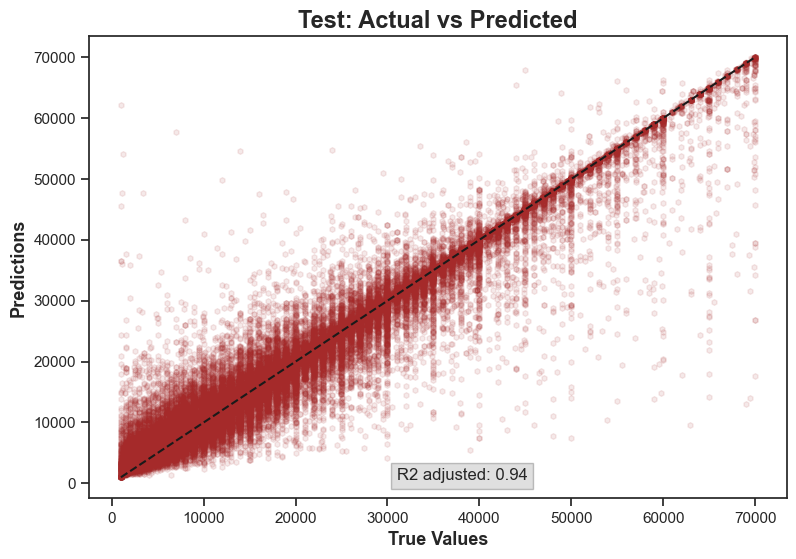

In [33]:
sns.set_style("ticks")

plt.figure(figsize = (9,6))
plt.scatter(x = y_test, y = rfr_y_pred, alpha = 0.1, c='brown', marker = 'h', s = 17)
plt.title('Test: Actual vs Predicted', fontsize = 17, weight = 'bold')
plt.ylabel('Predictions', fontsize = 13, weight = 'bold')
plt.xlabel('True Values', fontsize = 13, weight = 'bold')

plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], 'k', linestyle='--')
plt.text(31000,500,'R2 adjusted: {:.2f}'.format(adj_r2), 
         bbox=dict(facecolor='grey', edgecolor = 'k', alpha=0.25))

plt.show()

* Most predicted values are roughly similar to true values
* Higher prices seem to be underestimated by the model, leading to lower predicted prices
* Very high predicted values when true values are close to zero could be from the bias in the data (ads where people do not really want to sell (spam for advertising) or want to negotiate price so they choose very low price)

In [34]:
df_model = pd.DataFrame(
{
    'features':test_set.iloc[:, 1:].columns,
    'importance': rfr.feature_importances_
})
df_model = df_model.sort_values(by = ['importance'], ascending = False)
df_model

,features,importance
0,year,0.343163
4,odometer,0.213087
2,cylinders,0.203679
1,condition,0.063006
3,fuel_gas,0.057272
8,drive_fwd,0.031167
7,manufacturer_north america,0.014752
5,transmission_automatic,0.014183
13,type_truck,0.011295
11,type_pickup,0.010861


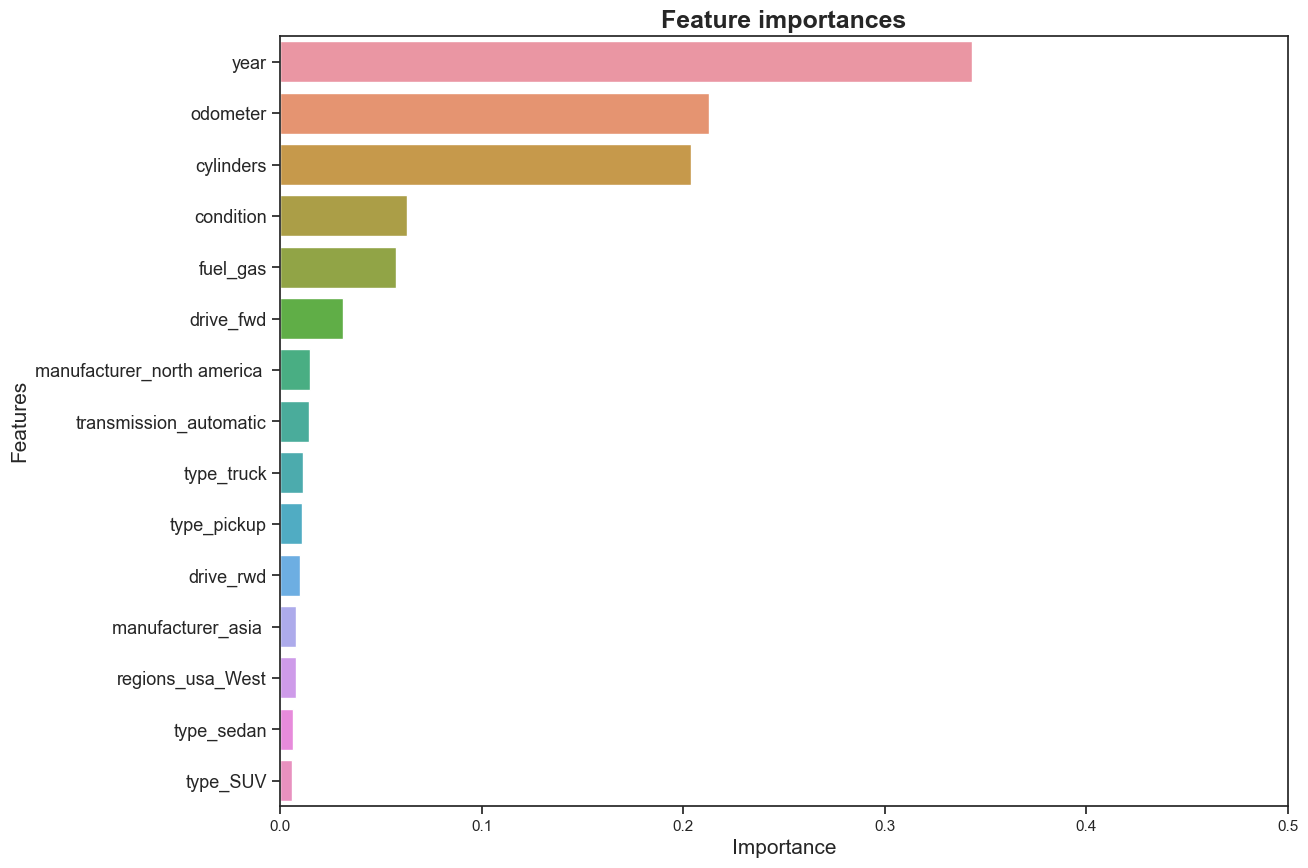

In [35]:
plt.figure(figsize = (13,10))

sns.barplot(y=df_model.features, x=df_model.importance)

plt.title('Feature importances', weight = 'bold', size = 18)
plt.yticks(fontsize = 13)
plt.xticks(np.arange(0,0.6,0.1))
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.show()

# Getting pos/neg effects with LIME

In [36]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=test_set.columns[1:],
                                                  class_names=['price'], verbose=True, mode='regression')

model = rfr

In [37]:
j = 7

exp = explainer.explain_instance(X_test[j], model.predict, num_features = 15)
exp.show_in_notebook(show_table=True)

Intercept 16747.050616158103
Prediction_local [35002.83923365]
Right: 33019.065882352945


In [38]:
pos_effect = ['year','condition', 'cylinders', 'regions_usa_West', 'type_truck', 
              'type_pickup', 'type_SUV', 'manufacturer_asia']


dict_effects = {feature:('green' if feature in pos_effect else 'red') for feature in df_model.features}

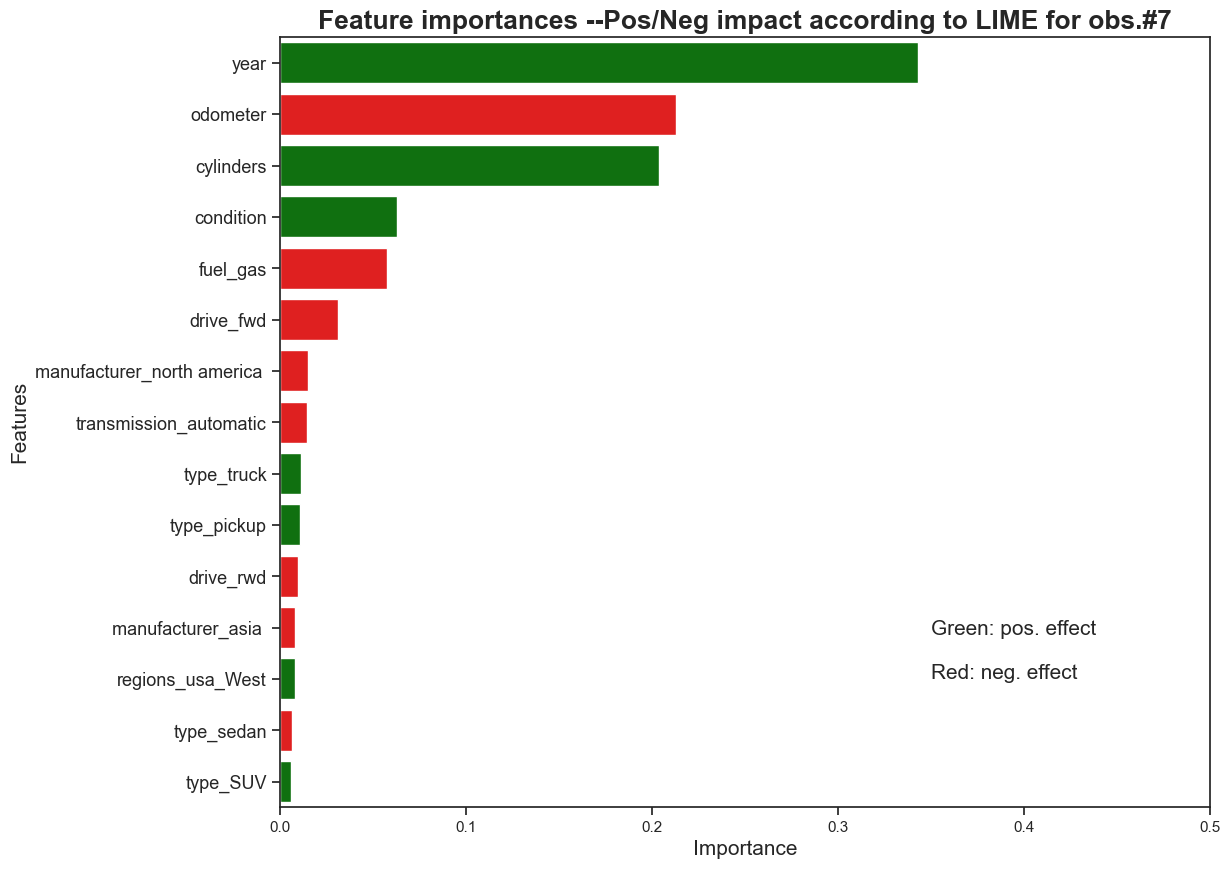

In [39]:
plt.figure(figsize = (12,10))

sns.barplot(y=df_model.features, x=df_model.importance, palette = dict_effects)

plt.title('Feature importances --Pos/Neg impact according to LIME for obs.#7', weight = 'bold', size = 19)
plt.yticks(fontsize = 13)
plt.xticks(np.arange(0,0.6,0.1))
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.text(0.35, 12, 'Green: pos. effect\n\nRed: neg. effect', size = 15)
plt.show()